# Basic Function of Simulated Annealing
The following are the core functions of the simulated annealing algorithm to solve TSP problems.

The key functions include `parse_tsp` and `parse_opt_tour` for reading TSP data and optimal tour sequences from files, `create_distance_matrix` to build a matrix of distances between cities, and `path_length` to calculate the total length of a given tour. 

The script implements two strategies for optimizing the tour: the 2-opt method (`two_opt_swap`) and a city movement approach (`move_city`). Additionally, it features various cooling schedules (linear, exponential, logarithmic) to control the algorithm's acceptance of new solutions as the process progresses. The main simulated annealing functions, `simulated_annealing_2_opt` and `simulated_annealing_move_city`, apply these strategies within the framework of simulated annealing. Lastly, `multiple_runs_simulated_annealing` facilitates multiple runs of the algorithm, enhancing the robustness of the solution by selecting the best tour found across all iterations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Read  file
def parse_tsp(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        cities = []
        for line in lines:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append([float(parts[1]), float(parts[2])])
        return np.array(cities)  # 使用NumPy数组

# Create distance matrix
def create_distance_matrix(cities):
    num_cities = len(cities)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        distance_matrix[i] = np.sqrt(np.sum((cities - cities[i])**2, axis=1))
    return distance_matrix

# calculate the path length from the distance matrix
def path_length(distance_matrix, tour):
    return np.sum(distance_matrix[tour, np.roll(tour, -1)])

# Parse the .opt.tour file to get the optimal path
def parse_opt_tour(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        opt_tour = []
        for line in lines:
            parts = line.split()
            if parts[0].isdigit():
                opt_tour.append(int(parts[0]) - 1)
        return np.array(opt_tour)  # 使用NumPy数组


In [5]:
# Parse eli51.tsp and eli51.opt.tour 
cities = parse_tsp('eil51.tsp.txt')
distance_matrix = create_distance_matrix(cities)
opt_tour = parse_opt_tour('eil51.opt.tour.txt')
opt_length = path_length(distance_matrix, opt_tour)


In [6]:
# 2-opt method
def two_opt_swap(tour, i, j):
    new_tour = list(tour[:i])
    new_tour.extend(reversed(tour[i:j + 1]))
    new_tour.extend(tour[j + 1:])
    return np.array(new_tour)

# Move city method
def move_city(tour, city_index, new_position):
    city = tour[city_index]
    new_tour = np.delete(tour, city_index)  # Delete the city of the original location
    new_tour = np.insert(new_tour, new_position, city)  # Insert the city in the new location
    return new_tour

In [7]:
# Cooling schedules
def linear_cooling(current_temp, alpha, iteration):
    return current_temp - alpha

def exponential_cooling(current_temp, alpha, iteration):
    return current_temp * alpha

def logarithmic_cooling(current_temp, alpha, iteration):
    return current_temp / (1 + alpha * np.log(1 + iteration))

In [28]:
# 2-opt SA Algorithm
def simulated_annealing_2_opt(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    current_tour = np.random.permutation(len(distance_matrix))
    current_length = path_length(distance_matrix, current_tour)
    lengths_over_iterations = [current_length]
    iteration = 1
    
    while current_temp > final_temp:
        for _ in range(len(distance_matrix)):
            i, j = np.sort(np.random.choice(len(distance_matrix), 2, replace=False))
            new_tour = two_opt_swap(current_tour, i, j)
            new_length = path_length(distance_matrix, new_tour)
            
            if new_length < current_length or np.random.rand() < np.exp((current_length - new_length) / current_temp):
                current_tour = new_tour
                current_length = new_length
         
        lengths_over_iterations.append(current_length)       
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1
        # current_temp *= alpha #默认使用exponential
    
    return current_tour, current_length, lengths_over_iterations

# Move city SA Algorithm
def simulated_annealing_move_city(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    current_tour = np.random.permutation(len(distance_matrix))
    current_length = path_length(distance_matrix, current_tour)
    lengths_over_iterations = [current_length]
    iteration = 1
    
    while current_temp > final_temp:
        for _ in range(len(cities)):
            city_index = np.random.randint(len(distance_matrix))
            new_position = np.random.randint(len(distance_matrix))
            new_tour = move_city(current_tour, city_index, new_position)
            new_length = path_length(distance_matrix, new_tour)
            
            if new_length < current_length or np.random.rand() < np.exp((current_length - new_length) / current_temp):
                current_tour = new_tour
                current_length = new_length
        
        lengths_over_iterations.append(current_length)    
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1
        # current_temp *= alpha #默认使用exponential

    return current_tour, current_length, lengths_over_iterations

In [18]:
# Multiple runs
def multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, method, cooling_schedule):
    best_tour = None
    best_length = float('inf')
    best_lengths_over_iterations = []

    for _ in range(runs):
        if method == '2-opt':
            tour, length, lengths = simulated_annealing_2_opt(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule)
        elif method == 'move_city':
            tour, length, lengths = simulated_annealing_move_city(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule)
        else:
            raise ValueError("Unknown method")

        if length < best_length:
            best_tour = tour
            best_length = length
            best_lengths_over_iterations = lengths

    return best_tour, best_length, best_lengths_over_iterations


# Run datas of eil51.tsp

In [68]:
def plot_tour(cities, tour, title, length, subplot_index):
    """Plot a tour on a specific subplot."""
    plt.subplot(1, 3, subplot_index)
    city_coords = np.array(cities)
    tour_coords = city_coords[np.array(tour)]
    plt.plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', markersize=5)
    plt.plot([tour_coords[-1, 0], tour_coords[0, 0]], [tour_coords[-1, 1], tour_coords[0, 1]], 'o-')  # Close the loop
    plt.title(f"{title}\nLength: {length:.2f}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    
# def plot_tour(cities, tour, title, length, subplot_index):
#     """Plot a tour on a specific subplot and include the length of the tour in the title."""
#     plt.subplot(1, 3, subplot_index)
#     city_coords = np.array(cities)
#     tour_coords = city_coords[np.array(tour) - 1]  # Adjusting for zero-based indexing if necessary
#     plt.plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', markersize=5)
#     plt.plot([tour_coords[-1, 0], tour_coords[0, 0]], [tour_coords[-1, 1], tour_coords[0, 1]], 'o-')  # Close the loop
#     # Include length in the title
#     plt.title(f"{title}\nLength: {length:.2f}")
#     plt.xlabel("X Coordinate")
#     plt.ylabel("Y Coordinate")


In [69]:
# Datas
cities51 = parse_tsp('eil51.tsp.txt')
distance_matrix = create_distance_matrix(cities)
opt_tour51 = parse_opt_tour('eil51.opt.tour.txt')
opt_length51 = path_length(distance_matrix, opt_tour51)


# Parameters
runs = 1  
initial_temp = 10000  
final_temp = 1   
alpha = 0.997         

# 2-opt
best_tour_2opt_51, best_length_2opt_51, _ = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, '2-opt', exponential_cooling)

# Move city
best_tour_move_city_51, best_length_move_city_51, _ = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, 'move_city', exponential_cooling)

print("Best path lengths found using 2-opt:", best_length_2opt_51)
print("Best path lengths found using move city:", best_length_move_city_51)
print("Optimal length:", opt_length51)

Best path lengths found using 2-opt: 454.29735474128137
Best path lengths found using move city: 453.36751171619073
Optimal length: 429.983311983384


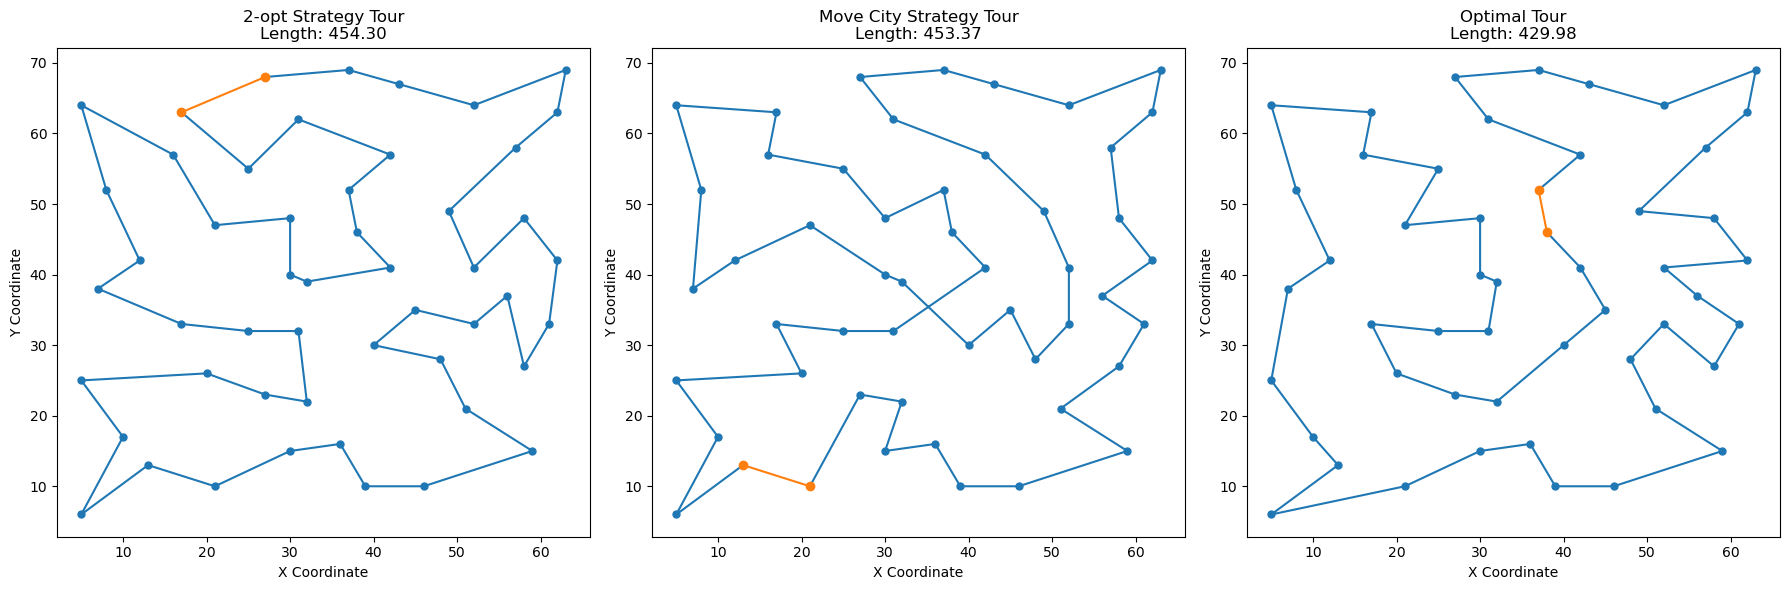

In [70]:
# PLot the path tour of different strategies and the optimal tour
plt.figure(figsize=(18, 6))

plot_tour(cities51, best_tour_2opt_51, "2-opt Strategy Tour", best_length_2opt_51, 1)
plot_tour(cities51, best_tour_move_city_51, "Move City Strategy Tour", best_length_move_city_51, 2)
plot_tour(cities51, opt_tour51, "Optimal Tour", opt_length51, 3)

plt.tight_layout()
plt.show()

# Run datas of a280.tsp

In [71]:
# Datas
cities280 = parse_tsp('a280.tsp.txt')
distance_matrix = create_distance_matrix(cities280)
opt_tour280 = parse_opt_tour('a280.opt.tour.txt')
opt_length280 = path_length(distance_matrix, opt_tour280)


# Parameters
runs = 1  
initial_temp = 10000  
final_temp = 1   
alpha = 0.997         

# 2-opt
best_tour_2opt_280, best_length_2opt_280, _ = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, '2-opt', exponential_cooling)

# Move city
best_tour_move_city_280, best_length_move_city_280, _ = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, 'move_city', exponential_cooling)

print("Best path lengths found using 2-opt:", best_length_2opt_280)
print("Best path lengths found using move city:", best_length_move_city_280)
print("Optimal length:", opt_length280)

Best path lengths found using 2-opt: 2926.1234459559173
Best path lengths found using move city: 5755.053414199076
Optimal length: 2586.7696475631597


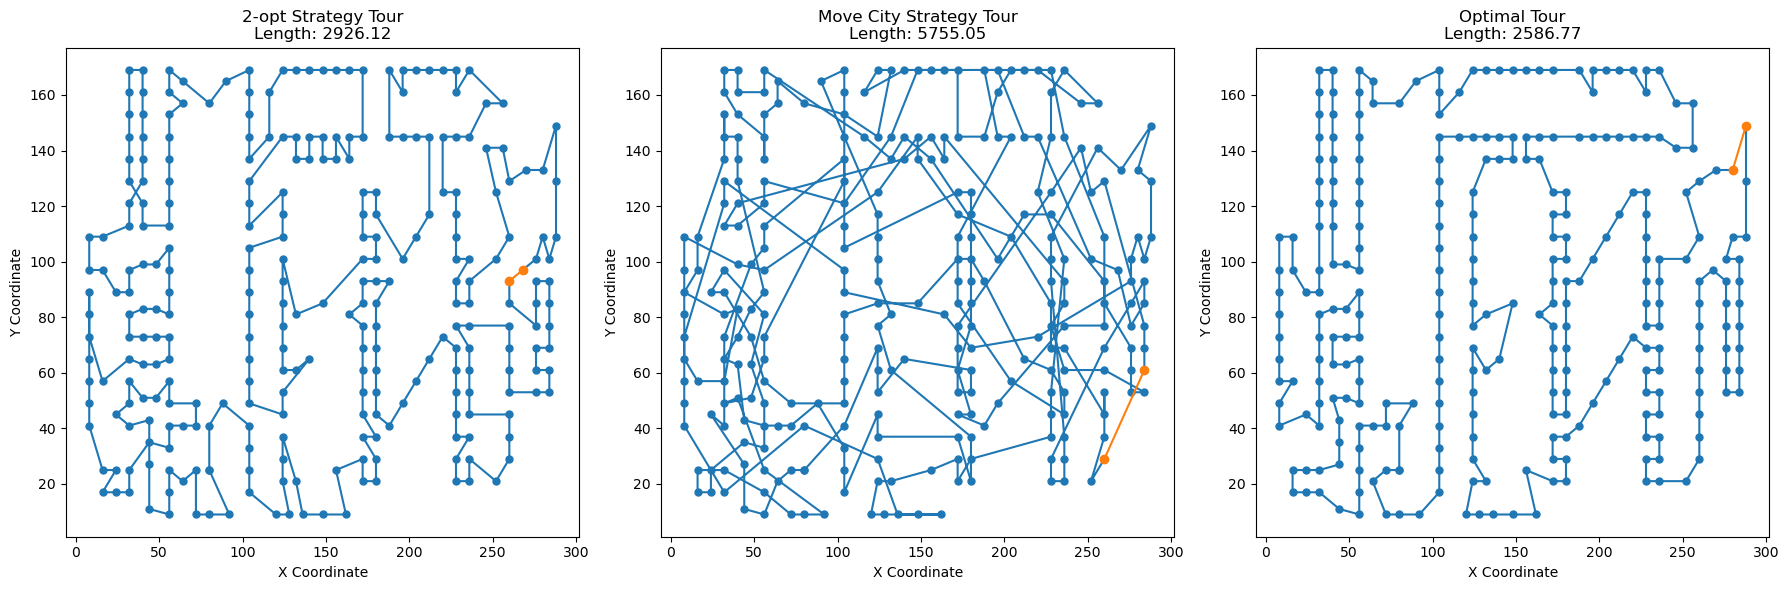

In [72]:
# PLot the path tour of different strategies and the optimal tour
plt.figure(figsize=(18, 6))

plot_tour(cities280, best_tour_2opt_280, "2-opt Strategy Tour", best_length_2opt_280, 1)
plot_tour(cities280, best_tour_move_city_280, "Move City Strategy Tour", best_length_move_city_280, 2)
plot_tour(cities280, opt_tour280, "Optimal Tour", opt_length280, 3)

plt.tight_layout()
plt.show()

# Run datas of pcb442.tsp

In [74]:
# Datas
cities442 = parse_tsp('pcb442.tsp.txt')
distance_matrix = create_distance_matrix(cities442)
opt_tour442 = parse_opt_tour('pcb442.opt.tour.txt')
opt_length442 = path_length(distance_matrix, opt_tour442)


# Parameters
runs = 1  
initial_temp = 10000  
final_temp = 1  
alpha = 0.997   
     
# 2-opt
best_tour_2opt_442, best_length_2opt_442, _ = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, '2-opt', exponential_cooling)

# Move city
best_tour_move_city_442, best_length_move_city_442, _ = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, 'move_city', exponential_cooling)

print("Best path lengths found using 2-opt:", best_length_2opt_442)
print("Best path lengths found using move city:", best_length_move_city_442)
print("Optimal length:", opt_length442)

Best path lengths found using 2-opt: 55259.74063272851
Best path lengths found using move city: 118492.38434151892
Optimal length: 50783.547513735306


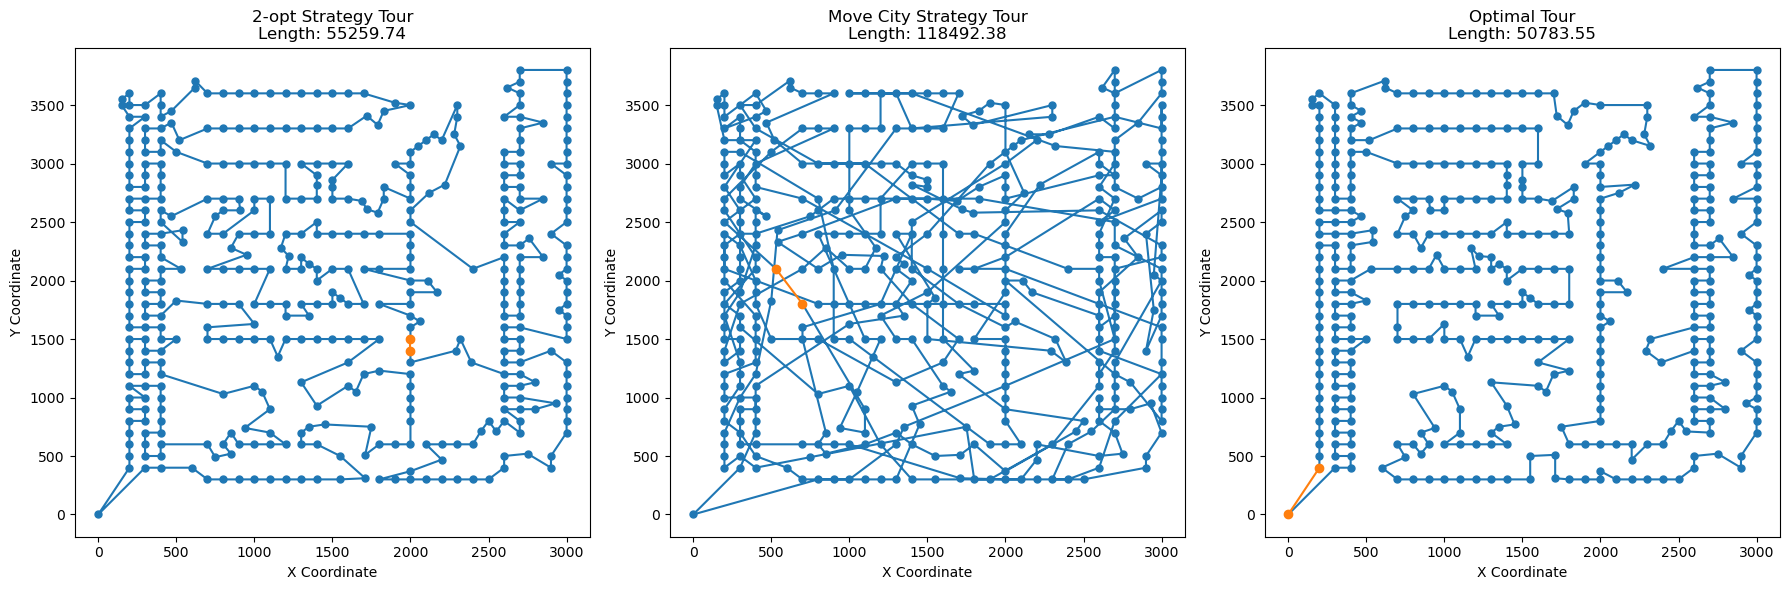

In [75]:
# PLot the path tour of different strategies and the optimal tour
plt.figure(figsize=(18, 6))

plot_tour(cities442, best_tour_2opt_442, "2-opt Strategy Tour", best_length_2opt_442, 1)
plot_tour(cities442, best_tour_move_city_442, "Move City Strategy Tour", best_length_move_city_442, 2)
plot_tour(cities442, opt_tour442, "Optimal Tour", opt_length442, 3)

plt.tight_layout()
plt.show()

# Compare the effects of different Cooling Schedules on convergence

This part focus on the analysis of "a280.tsp" file. 

In [13]:
# Datas
cities = parse_tsp('a280.tsp.txt')
distance_matrix = create_distance_matrix(cities)
opt_tour = parse_opt_tour('a280.opt.tour.txt')
opt_length280 = path_length(distance_matrix, opt_tour)


### Best length of different cooling schedules

In [14]:
# Paremeters
runs = 1  
initial_temp = 10000  
final_temp = 1       
alpha = 0.995        

# Different cooling schedules
for cooling_schedule in [linear_cooling, exponential_cooling, logarithmic_cooling]:
    best_tour_2opt, best_length_2opt = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, '2-opt', cooling_schedule)
    best_tour_move_city, best_length_move_city = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, 'move_city', cooling_schedule)
    
    print(f"Cooling Schedule: {cooling_schedule.__name__}")
    print(f"  Best Length with 2-opt: {best_length_2opt}")
    print(f"  Best Length with Move City: {best_length_move_city}\n")

Cooling Schedule: linear_cooling
  Best Length with 2-opt: 7833.412300296899
  Best Length with Move City: 9669.505052015878

Cooling Schedule: exponential_cooling
  Best Length with 2-opt: 3065.417076419654
  Best Length with Move City: 3944.1358554676417

Cooling Schedule: logarithmic_cooling
  Best Length with 2-opt: 17263.49709782513
  Best Length with Move City: 18388.006696103002



###  Convergence Plot


We plot 

In [20]:
# Parameters
runs = 5  
initial_temp = 10000  
final_temp = 1    
alpha = 0.997        

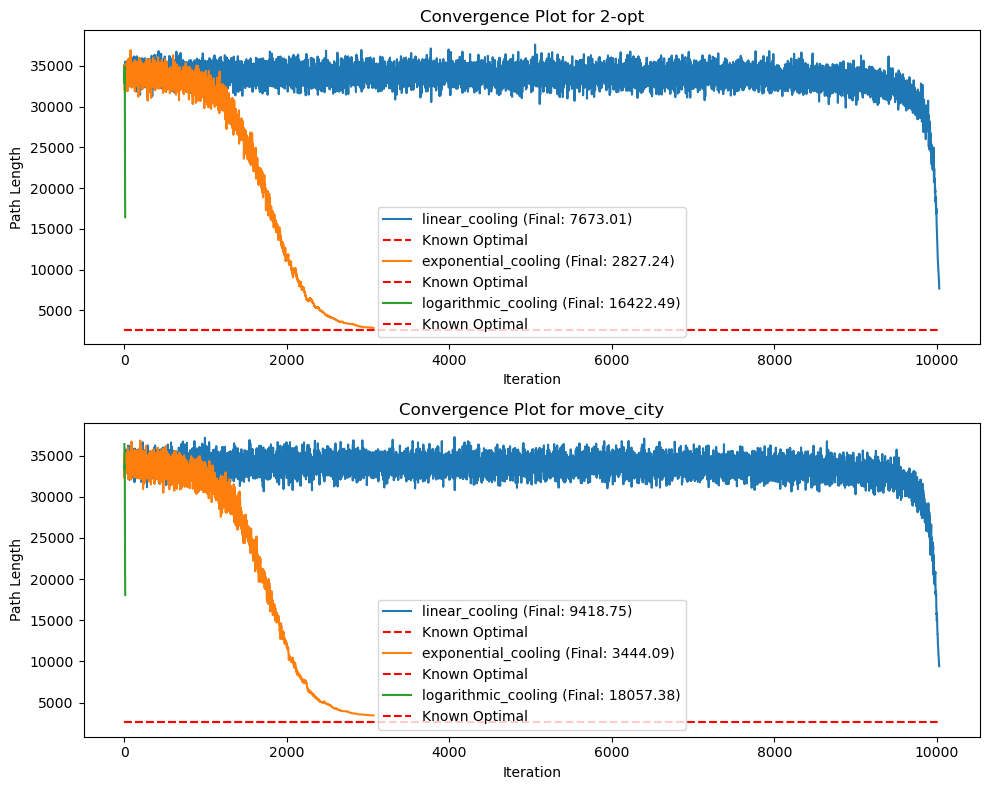

In [21]:
import matplotlib.pyplot as plt

# 收集不同冷却策略和优化方法的数据
data = {}
for cooling_schedule in [linear_cooling, exponential_cooling, logarithmic_cooling]:
    for method in ['2-opt', 'move_city']:
        _, best_length, lengths = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, method, cooling_schedule)
        data[(cooling_schedule.__name__, method)] = lengths
        
# 已知的最优路径长度
known_optimal_length = 2586.77 # 这里放入已知的最优路径长度

# 绘制收敛图并在图表上显示结果
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, method in enumerate(['2-opt', 'move_city']):
    for cooling_schedule_name in ['linear_cooling', 'exponential_cooling', 'logarithmic_cooling']:
        lengths = data[(cooling_schedule_name, method)]
        axs[i].plot(lengths, label=f"{cooling_schedule_name} (Final: {lengths[-1]:.2f})")
        axs[i].hlines(known_optimal_length, 0, len(lengths)-1, colors='r', linestyles='dashed', label='Known Optimal')

    axs[i].set_title(f'Convergence Plot for {method}')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Path Length')
    axs[i].legend()

plt.tight_layout()
plt.show()

绘制箱形图

In [31]:
def create_distance_matrix(cities):
    num_cities = len(cities)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i, j] = np.linalg.norm(cities[i] - cities[j])
    return distance_matrix

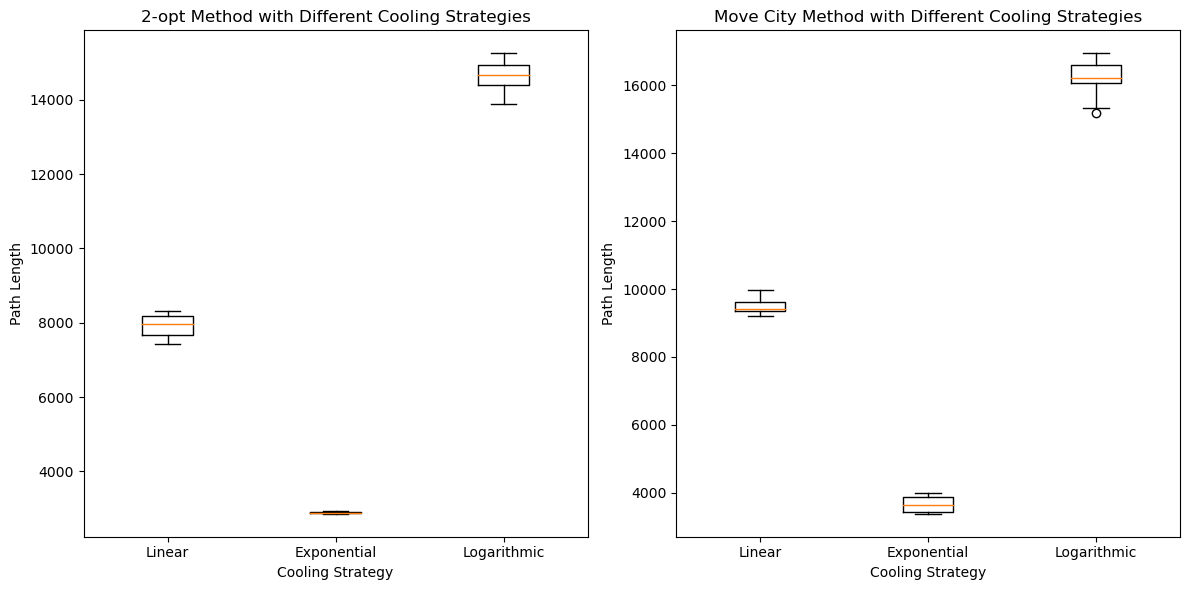

In [37]:
run = 10

# 收集数据 - 2-opt策略
results_2_opt_linear = [multiple_runs_simulated_annealing(distance_matrix, 1, initial_temp, final_temp, alpha, '2-opt', linear_cooling)[1] for _ in range(runs)]
results_2_opt_exponential = [multiple_runs_simulated_annealing(distance_matrix, 1, initial_temp, final_temp, alpha, '2-opt', exponential_cooling)[1] for _ in range(runs)]
results_2_opt_logarithmic = [multiple_runs_simulated_annealing(distance_matrix, 1, initial_temp, final_temp, alpha, '2-opt', logarithmic_cooling)[1] for _ in range(runs)]

# 收集数据 - 移动城市策略
results_move_city_linear = [multiple_runs_simulated_annealing(distance_matrix, 1, initial_temp, final_temp, alpha, 'move_city', linear_cooling)[1] for _ in range(runs)]
results_move_city_exponential = [multiple_runs_simulated_annealing(distance_matrix, 1, initial_temp, final_temp, alpha, 'move_city', exponential_cooling)[1] for _ in range(runs)]
results_move_city_logarithmic = [multiple_runs_simulated_annealing(distance_matrix, 1, initial_temp, final_temp, alpha, 'move_city', logarithmic_cooling)[1] for _ in range(runs)]

# 绘制箱形图 - 2-opt策略
data_2_opt = [results_2_opt_linear, results_2_opt_exponential, results_2_opt_logarithmic]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(data_2_opt, labels=['Linear', 'Exponential', 'Logarithmic'])
plt.title('2-opt Method with Different Cooling Strategies')
plt.ylabel('Path Length')
plt.xlabel('Cooling Strategy')

# 绘制箱形图 - 移动城市策略
data_move_city = [results_move_city_linear, results_move_city_exponential, results_move_city_logarithmic]
plt.subplot(1, 2, 2)
plt.boxplot(data_move_city, labels=['Linear', 'Exponential', 'Logarithmic'])
plt.title('Move City Method with Different Cooling Strategies')
plt.ylabel('Path Length')
plt.xlabel('Cooling Strategy')

plt.tight_layout()
plt.show()


不同markov chain length的收敛图

In [34]:
# 修改后的 simulated_annealing_2_opt 函数
def simulated_annealing_2_opt_markov(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule, markov_chain_length):
    current_temp = initial_temp
    current_tour = np.random.permutation(len(distance_matrix))
    current_length = path_length(distance_matrix, current_tour)
    lengths_over_iterations = [current_length]
    iteration = 1
    
    while current_temp > final_temp:
        for _ in range(markov_chain_length):
            i, j = np.sort(np.random.choice(len(distance_matrix), 2, replace=False))
            new_tour = two_opt_swap(current_tour, i, j)
            new_length = path_length(distance_matrix, new_tour)
            
            if new_length < current_length or np.random.rand() < np.exp((current_length - new_length) / current_temp):
                current_tour = new_tour
                current_length = new_length

        lengths_over_iterations.append(current_length)
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1
    
    return current_tour, current_length, lengths_over_iterations

# 修改后的 simulated_annealing_move_city 函数
def simulated_annealing_move_city_markov(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule, markov_chain_length):
    current_temp = initial_temp
    current_tour = np.random.permutation(len(distance_matrix))
    current_length = path_length(distance_matrix, current_tour)
    lengths_over_iterations = [current_length]
    iteration = 1
    
    while current_temp > final_temp:
        for _ in range(markov_chain_length):
            city_index = np.random.randint(len(distance_matrix))
            new_position = np.random.randint(len(distance_matrix))
            new_tour = move_city(current_tour, city_index, new_position)
            new_length = path_length(distance_matrix, new_tour)
            
            if new_length < current_length or np.random.rand() < np.exp((current_length - new_length) / current_temp):
                current_tour = new_tour
                current_length = new_length

        lengths_over_iterations.append(current_length)
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1

    return current_tour, current_length, lengths_over_iterations


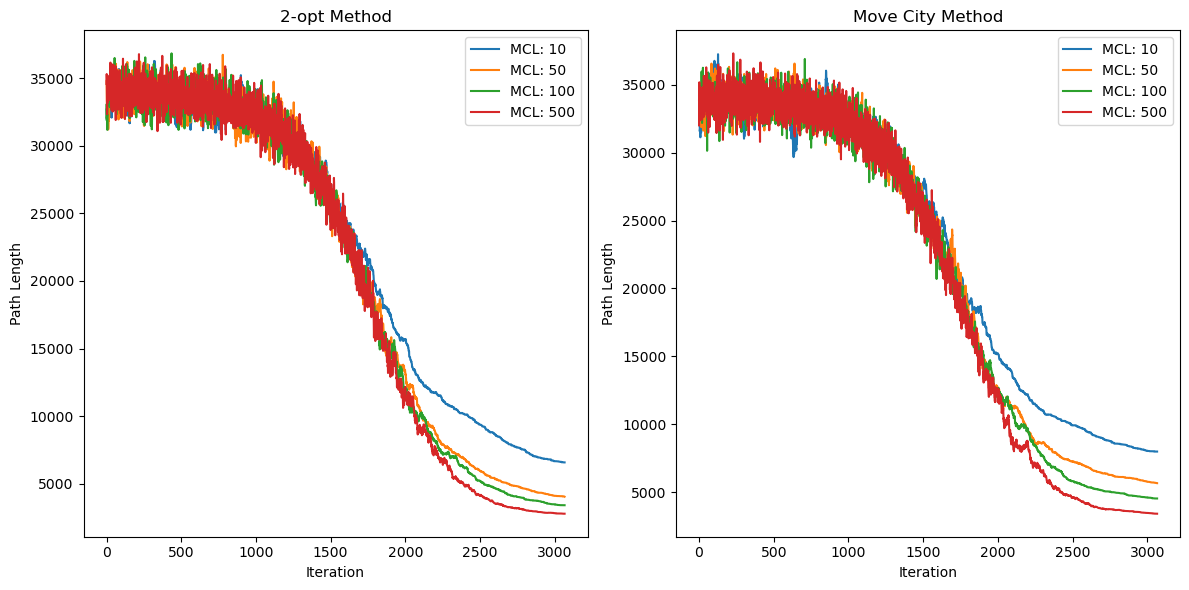

In [26]:
# 不同 Markov chain 长度的参数
markov_chain_lengths = [10, 50, 100, 500]

# 绘制收敛图
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 2-opt 方法
for mcl in markov_chain_lengths:
    _, _, lengths = simulated_annealing_2_opt_markov(distance_matrix, initial_temp, final_temp, alpha, exponential_cooling, mcl)
    axs[0].plot(lengths, label=f"MCL: {mcl}")
axs[0].set_title('2-opt Method')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Path Length')
axs[0].legend()

# 移动城市策略
for mcl in markov_chain_lengths:
    _, _, lengths = simulated_annealing_move_city_markov(distance_matrix, initial_temp, final_temp, alpha, exponential_cooling, mcl)
    axs[1].plot(lengths, label=f"MCL: {mcl}")
axs[1].set_title('Move City Method')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Path Length')
axs[1].legend()

plt.tight_layout()
plt.show()

继续箱形图

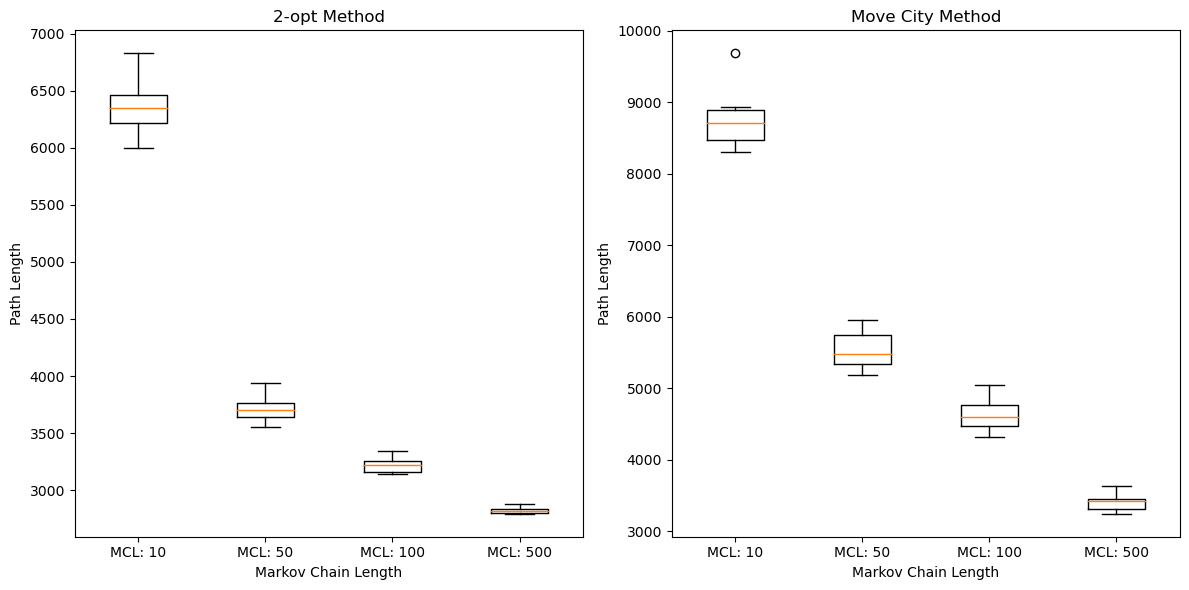

In [36]:
# 收集数据的函数
def collect_data_markov(distance_matrix, runs, method, markov_chain_lengths):
    results = {mcl: [] for mcl in markov_chain_lengths}
    for mcl in markov_chain_lengths:
        for _ in range(runs):
            if method == '2-opt':
                _, length, _ = simulated_annealing_2_opt_markov(distance_matrix, initial_temp, final_temp, alpha, exponential_cooling, mcl)
            else:  # 'move_city'
                _, length, _ = simulated_annealing_move_city_markov(distance_matrix, initial_temp, final_temp, alpha, exponential_cooling, mcl)
            results[mcl].append(length)
    return results

# 收集不同 Markov chain 长度的数据
results_2_opt = collect_data_markov(distance_matrix, runs, '2-opt', markov_chain_lengths)
results_move_city = collect_data_markov(distance_matrix, runs, 'move_city', markov_chain_lengths)

run = 10
# 绘制箱形图
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 2-opt 方法
data_2_opt = [results_2_opt[mcl] for mcl in markov_chain_lengths]
axs[0].boxplot(data_2_opt, labels=[f"MCL: {mcl}" for mcl in markov_chain_lengths])
axs[0].set_title('2-opt Method')
axs[0].set_xlabel('Markov Chain Length')
axs[0].set_ylabel('Path Length')

# 移动城市策略
data_move_city = [results_move_city[mcl] for mcl in markov_chain_lengths]
axs[1].boxplot(data_move_city, labels=[f"MCL: {mcl}" for mcl in markov_chain_lengths])
axs[1].set_title('Move City Method')
axs[1].set_xlabel('Markov Chain Length')
axs[1].set_ylabel('Path Length')

plt.tight_layout()
plt.show()